In [1]:
%load_ext autoreload
%autoreload 2

import torch

from text3d2video.rendering import render_depth_map
from text3d2video.utilities.video_util import pil_frames_to_clip

torch.set_grad_enabled(False)

In [2]:
from text3d2video.pipelines.generative_rendering_pipeline import (
    GenerativeRenderingPipeline
)
from text3d2video.pipelines.pipeline_utils import load_pipeline

device = torch.device("cuda")
dtype = torch.float16
sd_repo = "runwayml/stable-diffusion-v1-5"
controlnet_repo = "lllyasviel/control_v11f1p_sd15_depth"
pipe = load_pipeline(GenerativeRenderingPipeline, sd_repo, controlnet_repo)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [3]:
from text3d2video.artifacts.anim_artifact import AnimationArtifact
from text3d2video.utilities.ipython_utils import display_vid

n_frames = 20
animation = AnimationArtifact.from_wandb_artifact_tag('rumba:latest')
frame_indices = animation.frame_indices(n_frames)
frame_cams, frame_meshes = animation.load_frames(frame_indices)
verts_uvs, faces_uvs = animation.uv_data()

depths = render_depth_map(frame_meshes, frame_cams)

display_vid(pil_frames_to_clip(depths))

In [9]:
from pathlib import Path
from text3d2video.noise_initialization import FixedNoiseInitializer, RandomNoiseInitializer, UVNoiseInitializer
from text3d2video.pipelines.generative_rendering_pipeline import (
    GenerativeRenderingConfig,
)
from text3d2video.utilities.logging import GrLogger

module_paths = [
    # "down_blocks.0.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.0.attentions.1.transformer_blocks.0.attn1",
    # "down_blocks.1.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.1.attentions.1.transformer_blocks.0.attn1",
    # "down_blocks.2.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.2.attentions.1.transformer_blocks.0.attn1",
    "mid_block.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.2.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.2.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.2.transformer_blocks.0.attn1",
]

gr_config = GenerativeRenderingConfig(
    do_pre_attn_injection=True,
    do_post_attn_injection=True,
    feature_blend_alpha=0.8,
    attend_to_self_kv=False,
    mean_features_weight=0.5,
    chunk_size=5,
    num_keyframes=3,
    num_inference_steps=15,
    guidance_scale=7.5,
    controlnet_conditioning_scale=1.0,
    module_paths=module_paths,
)

prompt = "Deadpool"

generator = torch.Generator(device="cuda")
generator.manual_seed(1)

logger = GrLogger(Path("data.h5"), n_save_times=10, n_save_frames=10)
logger.delete_data()
logger.open_write()
logger.enabled = False

noise_initializer = FixedNoiseInitializer()
noise_initializer = RandomNoiseInitializer()
noise_initializer = UVNoiseInitializer(noise_texture_res=40)

video_frames = pipe(
    prompt,
    frame_meshes,
    frame_cams,
    verts_uvs,
    faces_uvs,
    generative_rendering_config=gr_config,
    noise_initializer=noise_initializer,
    generator=generator,
    logger=logger,
)

100%|██████████| 15/15 [01:13<00:00,  4.88s/it]


In [10]:
from einops import rearrange

ts = logger.get_key_values("textures_cond", "t")
layers = logger.get_key_values("textures_cond", "layer")
layer = layers[1]

textures = [logger.read("textures_cond", t=t, layer=layer, return_pt=True) for t in ts]
textures = torch.stack(textures)
textures = rearrange(textures, "t h w c -> t c h w")

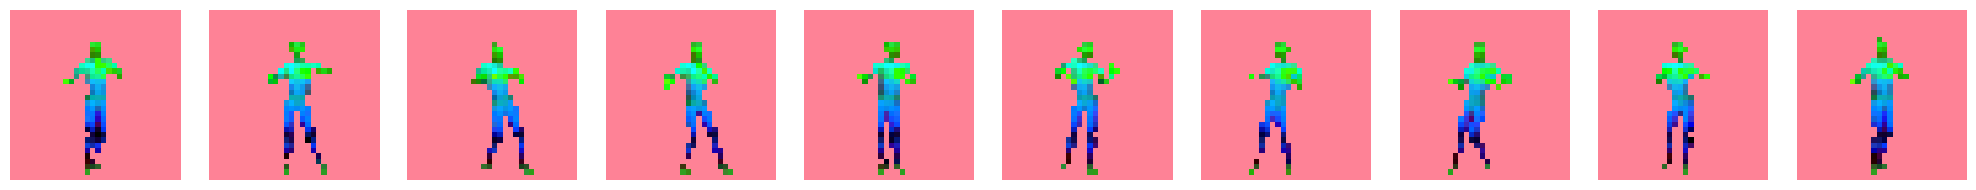

torch.Size([10, 640, 32, 32])


In [11]:
from text3d2video.feature_visualization import RgbPcaUtil
from text3d2video.utilities.ipython_utils import display_ims

frame_indices = logger.get_key_values("rendered_cond", "frame_i")

layer = layers[4]
t = ts[8]

rendered_features = torch.stack(
    [
        logger.read("rendered_cond", t=t, layer=layer, frame_i=i, return_pt=True)
        for i in frame_indices
    ]
)

pca_features = rearrange(rendered_features[0], "c h w -> (h w) c")
pca = RgbPcaUtil.init_from_features(pca_features)
rendered_ims = [pca.feature_map_to_rgb_pil(f) for f in rendered_features]
display_ims(rendered_ims)

print(rendered_features.shape)

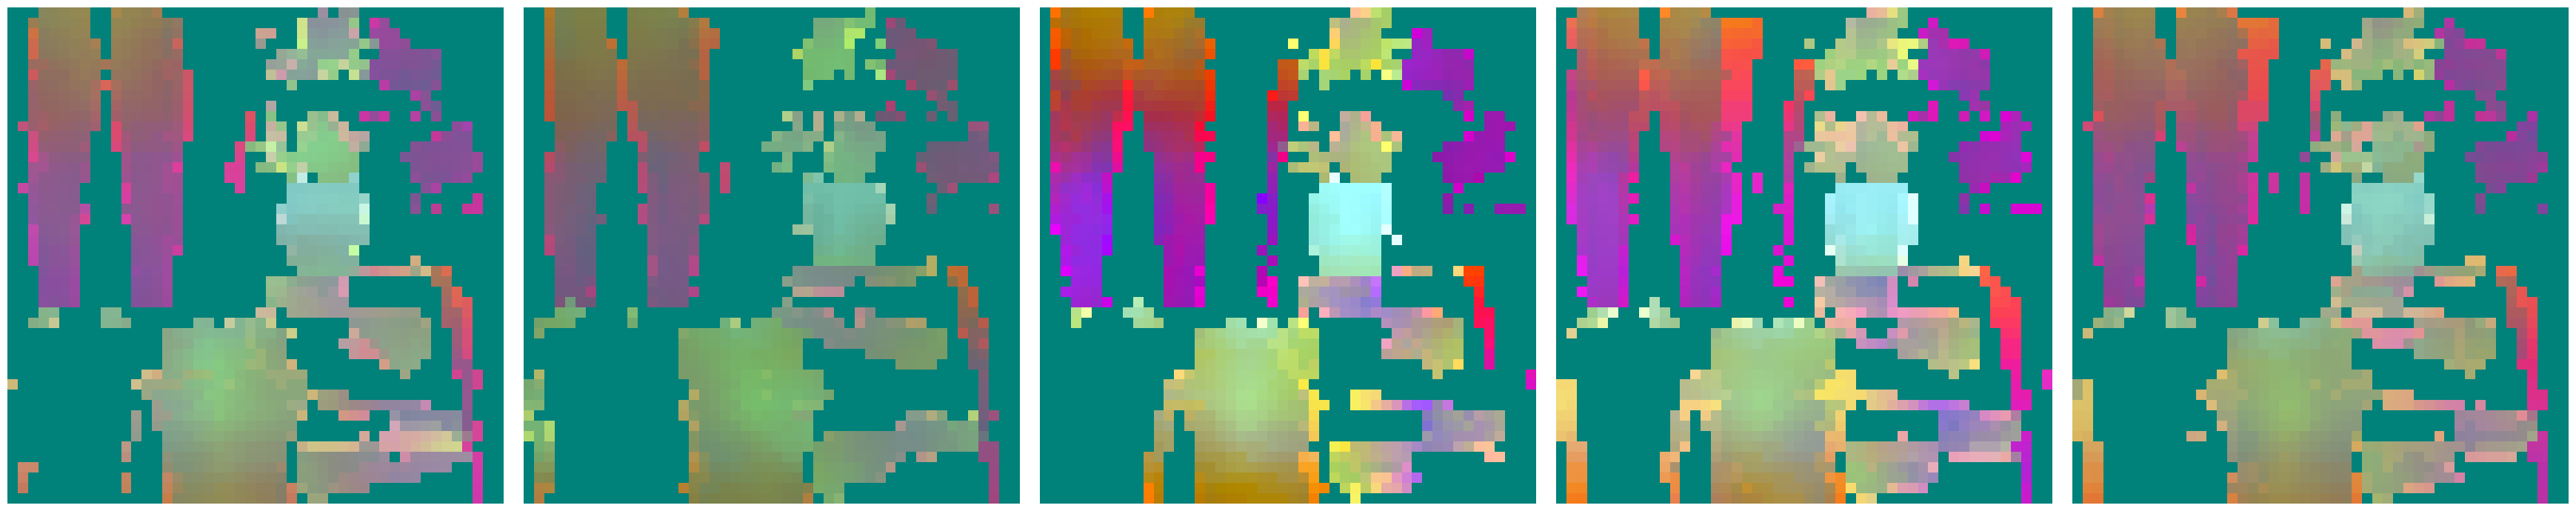

In [12]:
from text3d2video.feature_visualization import RgbPcaUtil
from text3d2video.util import ordered_sample
from text3d2video.utilities.ipython_utils import display_ims

mid_idx = textures.shape[0] // 2
features = rearrange(textures[mid_idx], "c h w -> (h w) c")
pca = RgbPcaUtil.init_from_features(features)

textures_pil = [pca.feature_map_to_rgb_pil(t) for t in textures]
display_ims(ordered_sample(textures_pil, 5), scale=7)

In [13]:
display_vid(pil_frames_to_clip(video_frames), resolution=512)